# **Pré-processamento e exploração de dados**
Aqui vou explorar as características da série temporal
- Plotar gráficos
- Analisar
  - distribuição
  - sazonalidade
  - tendência
  - auto-correlação
- Teste de estacionariedade

## **1. Prepare o ambiente**

<br/>

### Imports

In [1]:
# Análise de dados
import numpy as np
import pandas as pd

# Métricas
import statistics

# Plotting
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

import matplotlib.pyplot as plt
from matplotlib import pyplot

# statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa as tsa
import statsmodels.api as sm

# Outros
from IPython.display import Image
import warnings
import pprint
import openpyxl
import datetime
import os

<br/>

### Definir configuração

In [2]:
%matplotlib inline

# Carrega a extensão "autoreload" para que o código possa mudar
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set_context("paper")  # Definindo o contexto para "paper"
sns.set_theme(style='darkgrid',
    palette='deep',
    color_codes=True,
    rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Suprima avisos desnecessários para que a apresentação pareça limpa
warnings.filterwarnings('ignore')

In [3]:
# plt.style.use('seaborn')  # fivethirtyeight - Removido
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set_theme(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set_theme(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

---

## **2. Compreensão dos dados**

<br/>

### Load Data

In [60]:
%%time

df1 = pd.read_excel(r'C:\Users\Lucas S\OneDrive\Documents\ADM_UFPB\TCC1\db_soja_modificado\db_soja_ESALQ_BM_FBOVESPA_PARANAGUÁ_diário.xlsx',)
print(df1)

CPU times: total: 422 ms
Wall time: 653 ms


<br/>

### **Describe Data**

In [ ]:
# Este comando fornece um resumo conciso do DataFrame, incluindo o número de entradas não nulas em cada coluna e o tipo de dados.
df1.info()

In [ ]:
list_columns = (df1.columns).tolist()

print("-"*25, "List Columns", "-"*25, end='\n')
display(list_columns)

In [ ]:
# Este comando gera estatísticas descritivas.
df1.describe()

In [ ]:
# Este comando retorna o número de elementos únicos em cada coluna.
df1.nunique()

In [ ]:
# Este comando retorna a moda de cada coluna de dados.
df1.mode(dropna=False, numeric_only=True)

In [ ]:
# Este comando retorna a mediana de cada coluna de dados.
df1.median()

In [ ]:
# Este comando verifica se há algum valor nulo no DataFrame.
df1.isnull().any()

In [ ]:
# Este comando verifica se há alguma linha duplicada no DataFrame.
df1.duplicated().any()

---

## **3. Preparação de dados: limpeza**
A análise da ST é univariada, ou seja, somente a coluna `preço` em relação ao tempo que será prevista. Isto vai garantir uma melhor comparação entre os modelos estatísticos, de aprendizado de máquina e aprendizado profundo.

### Formatação das Colunas

#### Data


In [61]:

df1['data'] = pd.to_datetime(df1['data'])
df1 = df1.set_index('data').asfreq('D')

In [11]:
df1

,à_vista_real,à_vista_dolar
data,,
2006-03-13,27.66,12.96
2006-03-14,27.45,12.91
2006-03-15,27.58,13.00
2006-03-16,26.97,12.78
2006-03-17,26.96,12.68
...,...,...
2023-12-24,NaN,NaN
2023-12-25,NaN,NaN
2023-12-26,143.71,29.78


In [62]:
df1 = df1.interpolate(method='time').round(2)

In [13]:
df1

,à_vista_real,à_vista_dolar
data,,
2006-03-13,27.66,12.96
2006-03-14,27.45,12.91
2006-03-15,27.58,13.00
2006-03-16,26.97,12.78
2006-03-17,26.96,12.68
...,...,...
2023-12-24,145.17,29.97
2023-12-25,144.44,29.88
2023-12-26,143.71,29.78


In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6500 entries, 2006-03-13 to 2023-12-28
Freq: D
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   à_vista_real   6500 non-null   float64
 1   à_vista_dolar  6500 non-null   float64
dtypes: float64(2)
memory usage: 152.3 KB


In [63]:
df1['data'] = df1.index

In [64]:
df1 = df1.reindex(['data'] + list(df1.columns[:-1]), axis=1)

In [65]:
df1

,data,à_vista_real,à_vista_dolar
data,,,
2006-03-13,2006-03-13,27.66,12.96
2006-03-14,2006-03-14,27.45,12.91
2006-03-15,2006-03-15,27.58,13.00
2006-03-16,2006-03-16,26.97,12.78
2006-03-17,2006-03-17,26.96,12.68
...,...,...,...
2023-12-24,2023-12-24,145.17,29.97
2023-12-25,2023-12-25,144.44,29.88
2023-12-26,2023-12-26,143.71,29.78


<br/>

### **Verify Data Quality**
- Check index
- Check for irrelevant values
- Check for outliers

<br/>

#### Check Index

In [10]:
df1.index

DatetimeIndex(['2006-03-13', '2006-03-14', '2006-03-15', '2006-03-16',
               '2006-03-17', '2006-03-18', '2006-03-19', '2006-03-20',
               '2006-03-21', '2006-03-22',
               ...
               '2023-12-19', '2023-12-20', '2023-12-21', '2023-12-22',
               '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
               '2023-12-27', '2023-12-28'],
              dtype='datetime64[ns]', name='data', length=6500, freq='D')

<br/>

#### Check for outliers

In [11]:
def plot_box_plot(df: 'dataframe', data_set_name: str, xlim=None):
    fig, ax = plt.subplots(figsize=(20, 10))  # Aumente o primeiro valor para tornar o gráfico mais largo

    if xlim is not None:
        plt.xlim(*xlim)

    plt.title(f"Boxplot Horizontal de Preço")

    plt.ylabel('Variáveis ​​dependentes')
    plt.xlabel('Medição x')
    ax = sns.boxplot(data = df,
                    orient = 'h',
                    palette = 'Set2',
                    notch = False)  # box instead of notch shape

    plt.show()

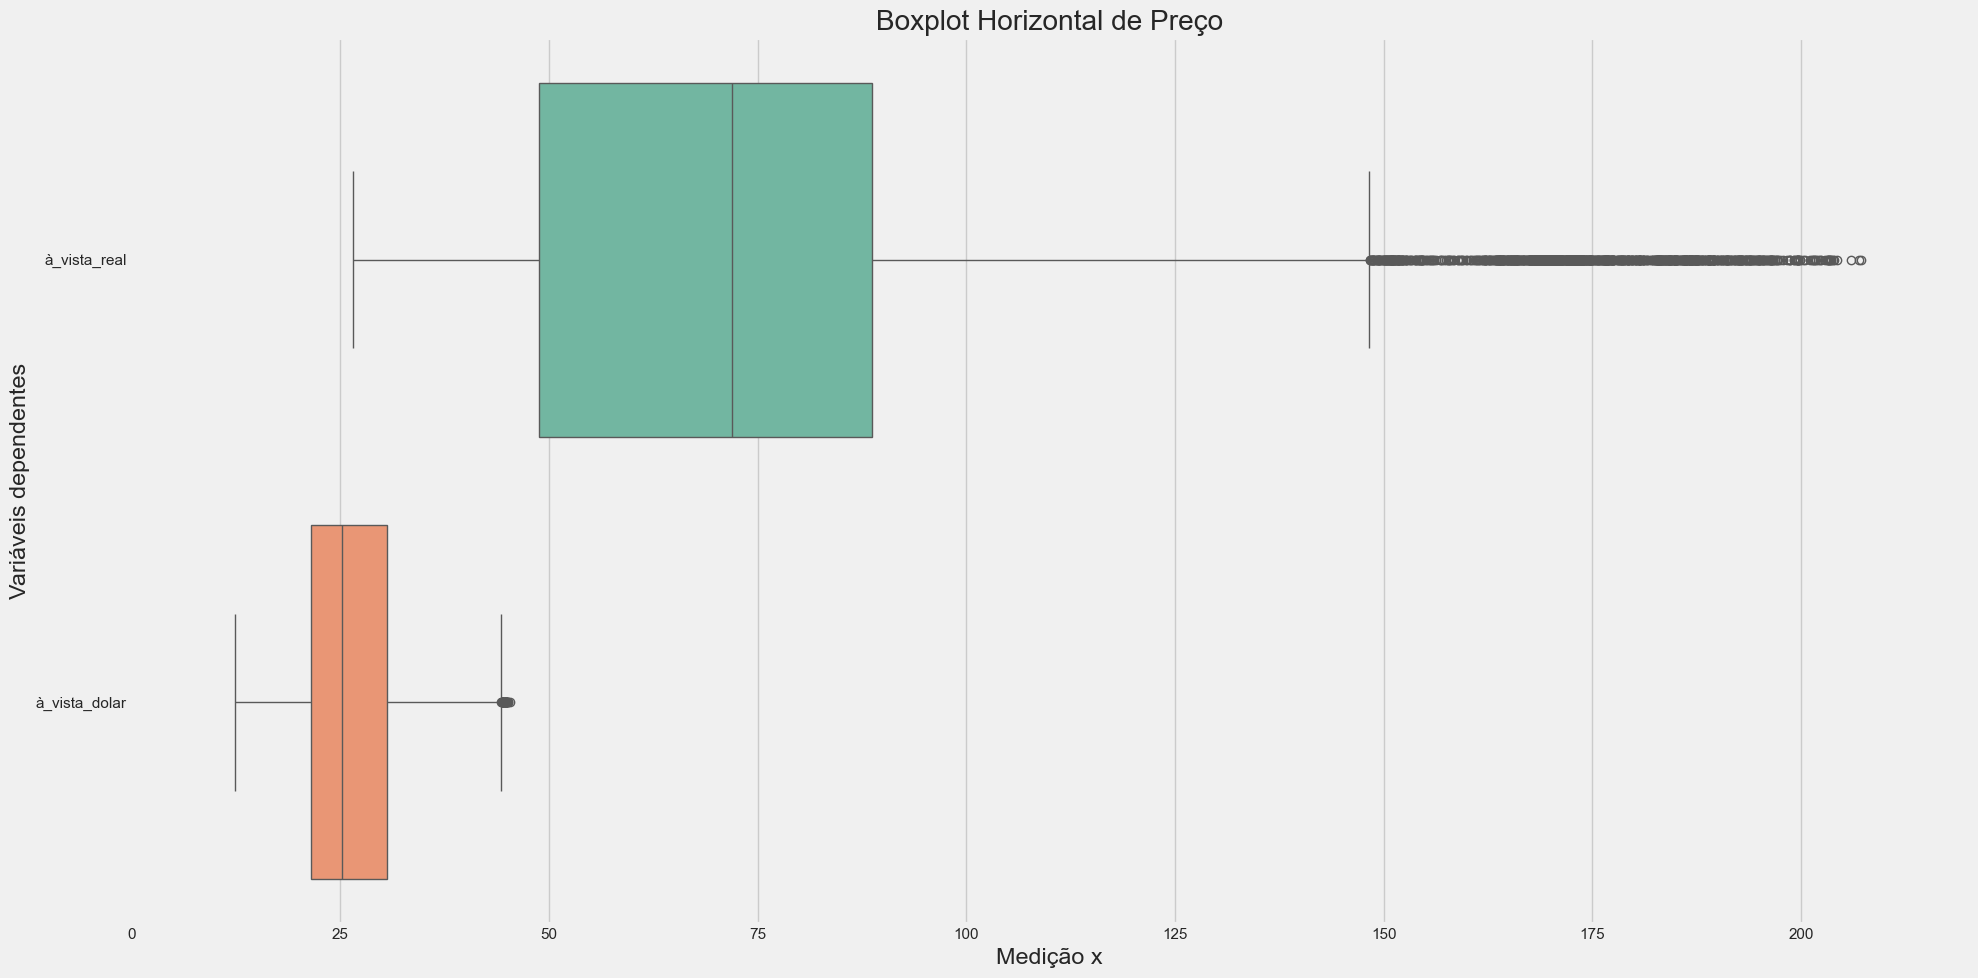

In [12]:
plot_box_plot(df1,
              'à_vista_dolar',
              (0, 220))

---

## **4. Compreensão de dados: estatísticas e gráficos**
### **Exploração de dados**
- Análise dos componentes da ST
- distribuição
- sazonalidade
- tendência
- ruídos

In [66]:
def save_image(img: 'matplotlib',
               name: str,
               path: str = 'reports/images/'):

    fig = img.get_figure()
    fig.savefig(f"reports/images/{name}.png")

    return f"Image {name} saved."

#### Distribuição

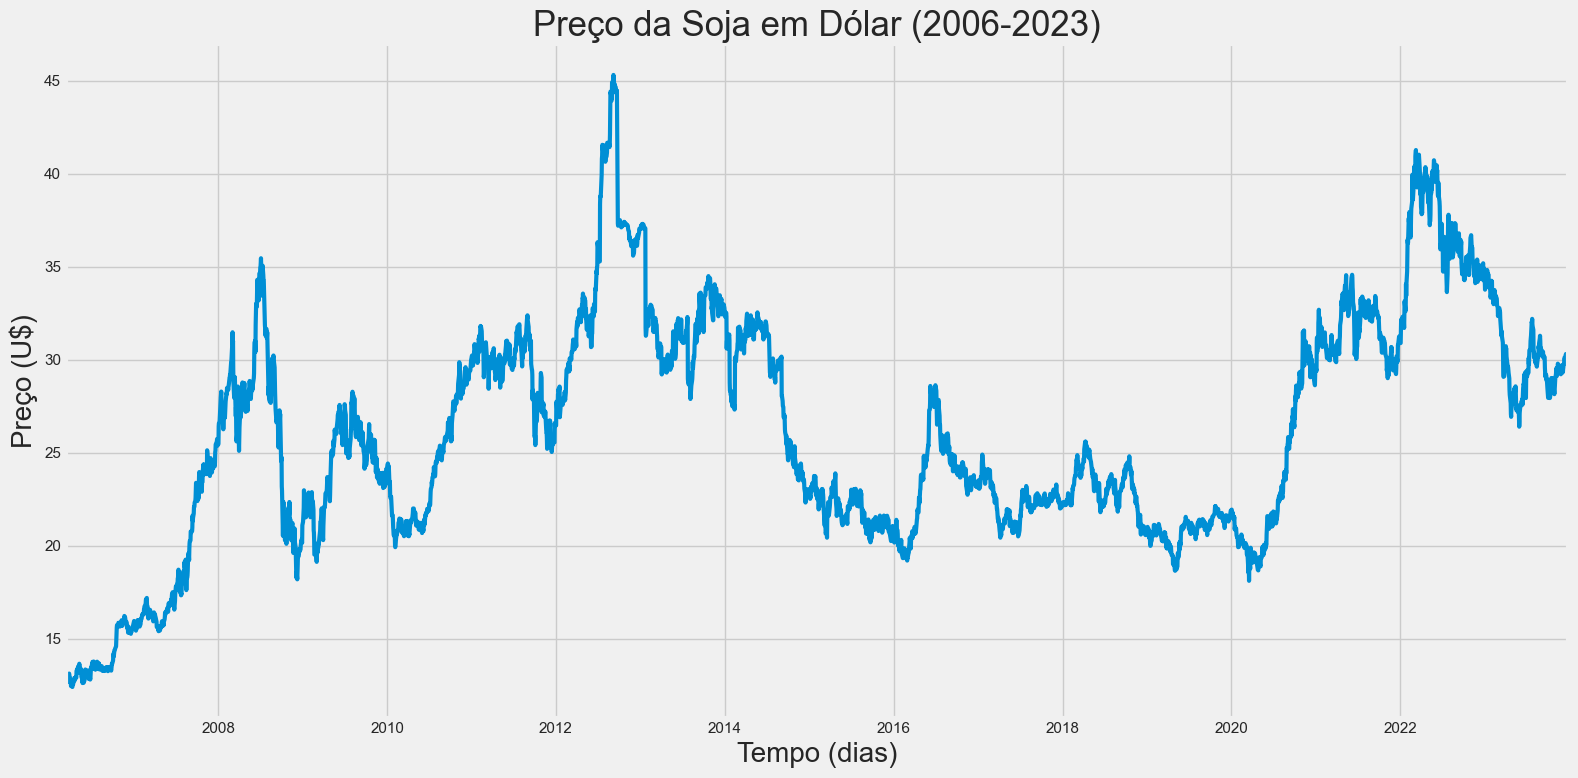

In [28]:
img_distr_line = df1['à_vista_dolar'].plot(linewidth=3)

plt.title(f'Preço da Soja em Dólar (2006-2023)', fontsize=25)
plt.xlabel("Tempo (dias)", fontsize=20)
plt.ylabel("Preço (U$)", fontsize=20)
plt.grid(True)

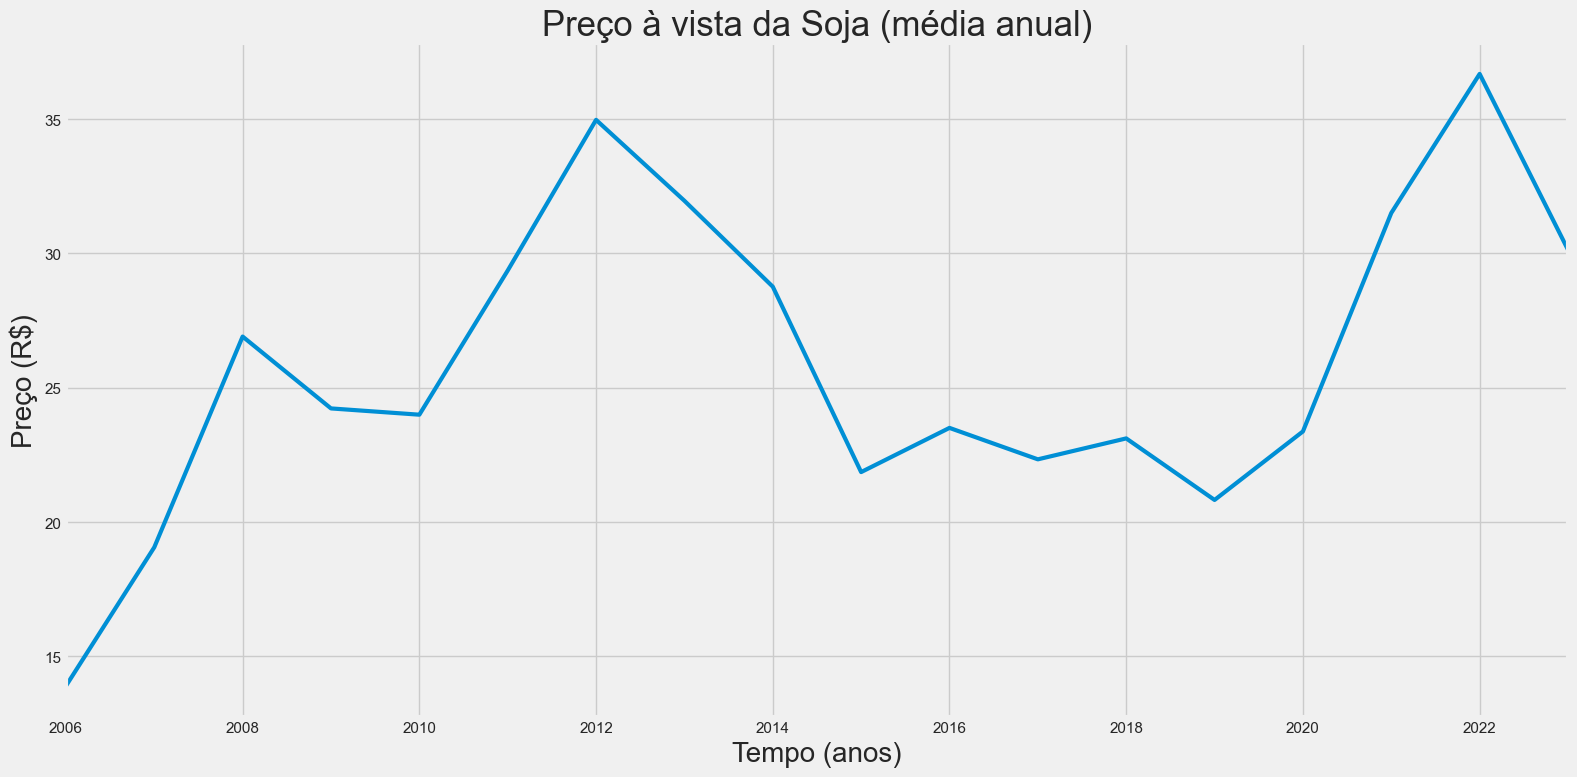

In [107]:
line_plot_rasemple_anual = df1['à_vista_dolar'].resample('A').mean().plot(linewidth=3)

plt.title(f'Preço à vista da Soja (média anual)', fontsize=25)
plt.xlabel("Tempo (anos)", fontsize=20)
plt.ylabel("Preço (R$)", fontsize=20)
plt.grid(True)
plt.show()

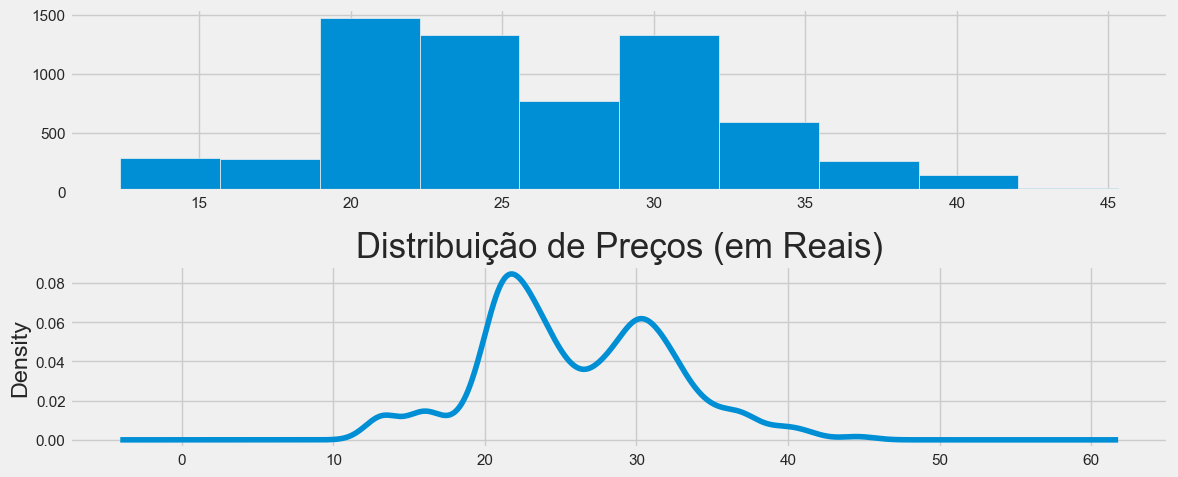

In [108]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,5))
df1['à_vista_dolar'].hist(ax=ax1)
df1['à_vista_dolar'].plot(kind='kde', ax=ax2)
plt.title(f'Distribuição de Preços (em Reais)', fontsize=25)
plt.show();

Não é uma dietribuição perfeitamente gausiana

<br/>

### **Decomposição da Série Temporal**
- O objetivo é decompor a ST
- A ST aparenta ter duas tendências sendo os dois casos uma tendência linear do que exponencial, então a decomposição será `additive`

In [67]:
decomposition_add = seasonal_decompose(df1['à_vista_dolar'],
                                       model='additive',
                                       period=30)
trend = decomposition_add.trend
seasonal = decomposition_add.seasonal
residual = decomposition_add.resid

<Axes: xlabel='data', ylabel='Resíduo'>

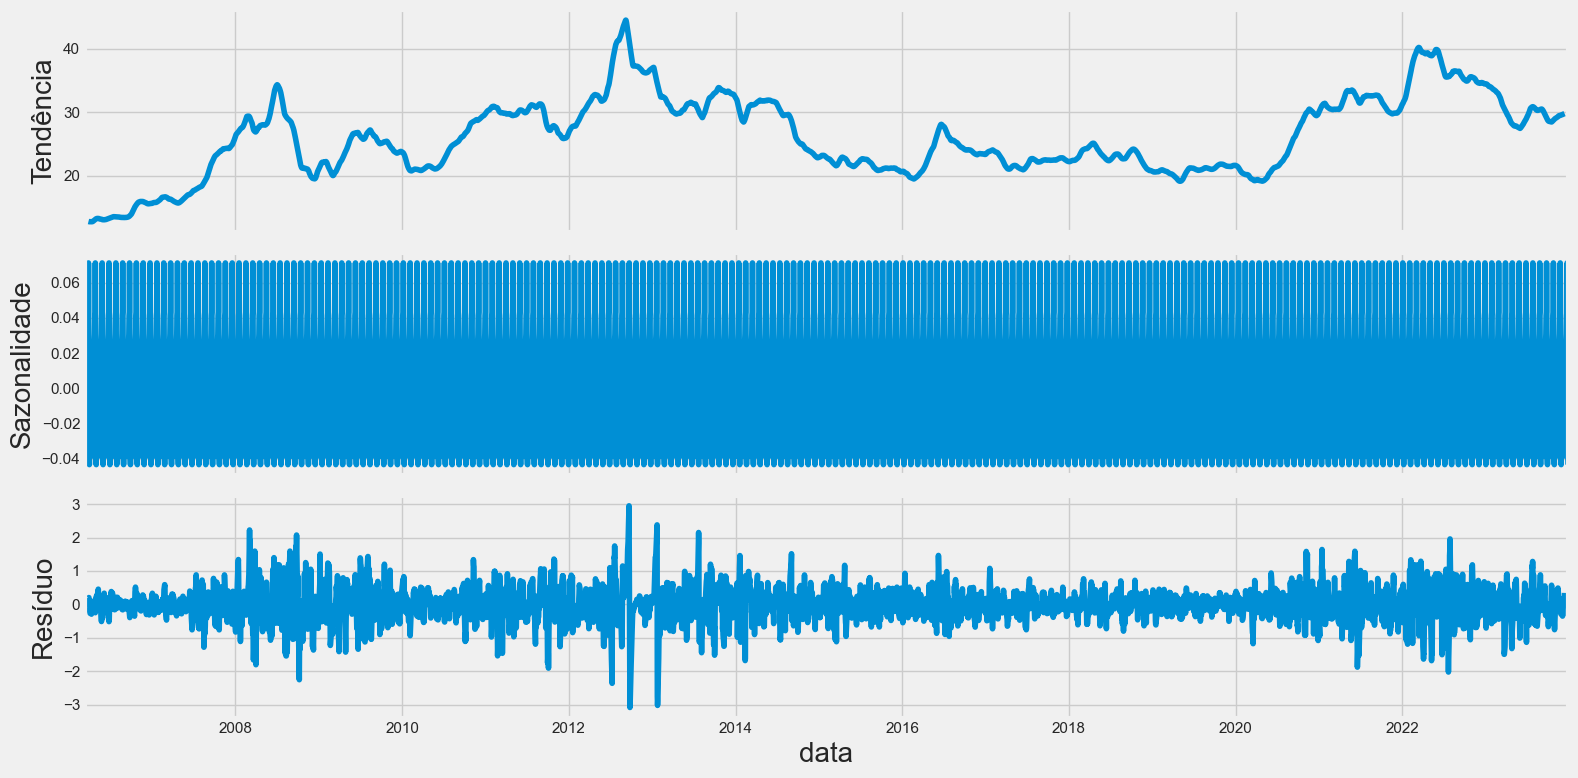

In [68]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True)

axes[0].set_ylabel('Tendência', fontsize=20)
axes[1].set_ylabel('Sazonalidade', fontsize=20)
axes[2].set_ylabel('Resíduo', fontsize=20)
axes[2].set_xlabel('Tempo dias', fontsize=20)

decomposition_add.trend.plot(ax=axes[0])
decomposition_add.seasonal.plot(ax=axes[1])
decomposition_add.resid.plot(ax=axes[2])

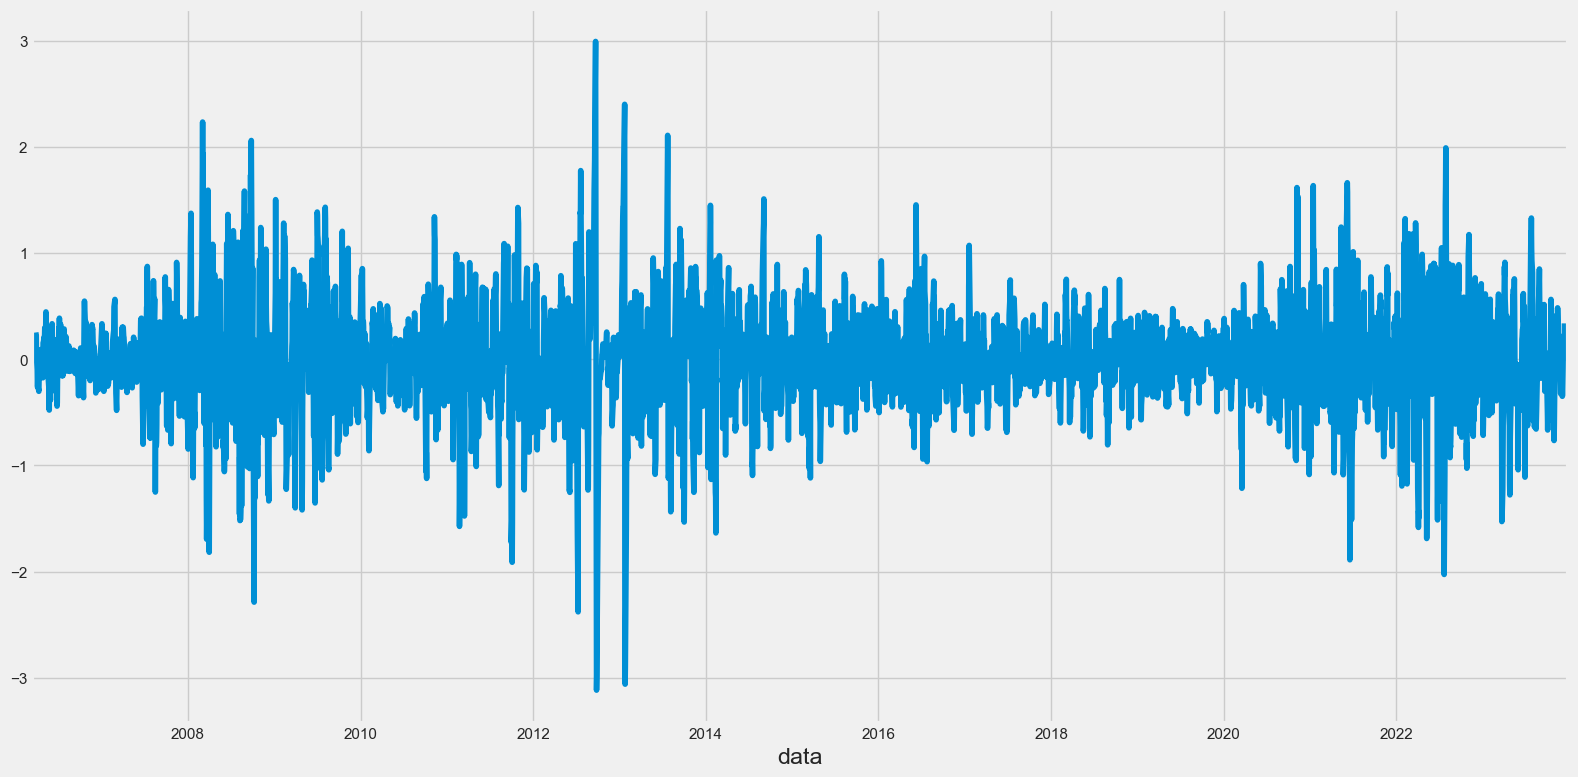

In [17]:
df_without_trend = df1['à_vista_dolar'] - trend
img_df_without_trend = df_without_trend.plot()
#save_image(img=img_df_without_trend, name='img_df_without_trend')

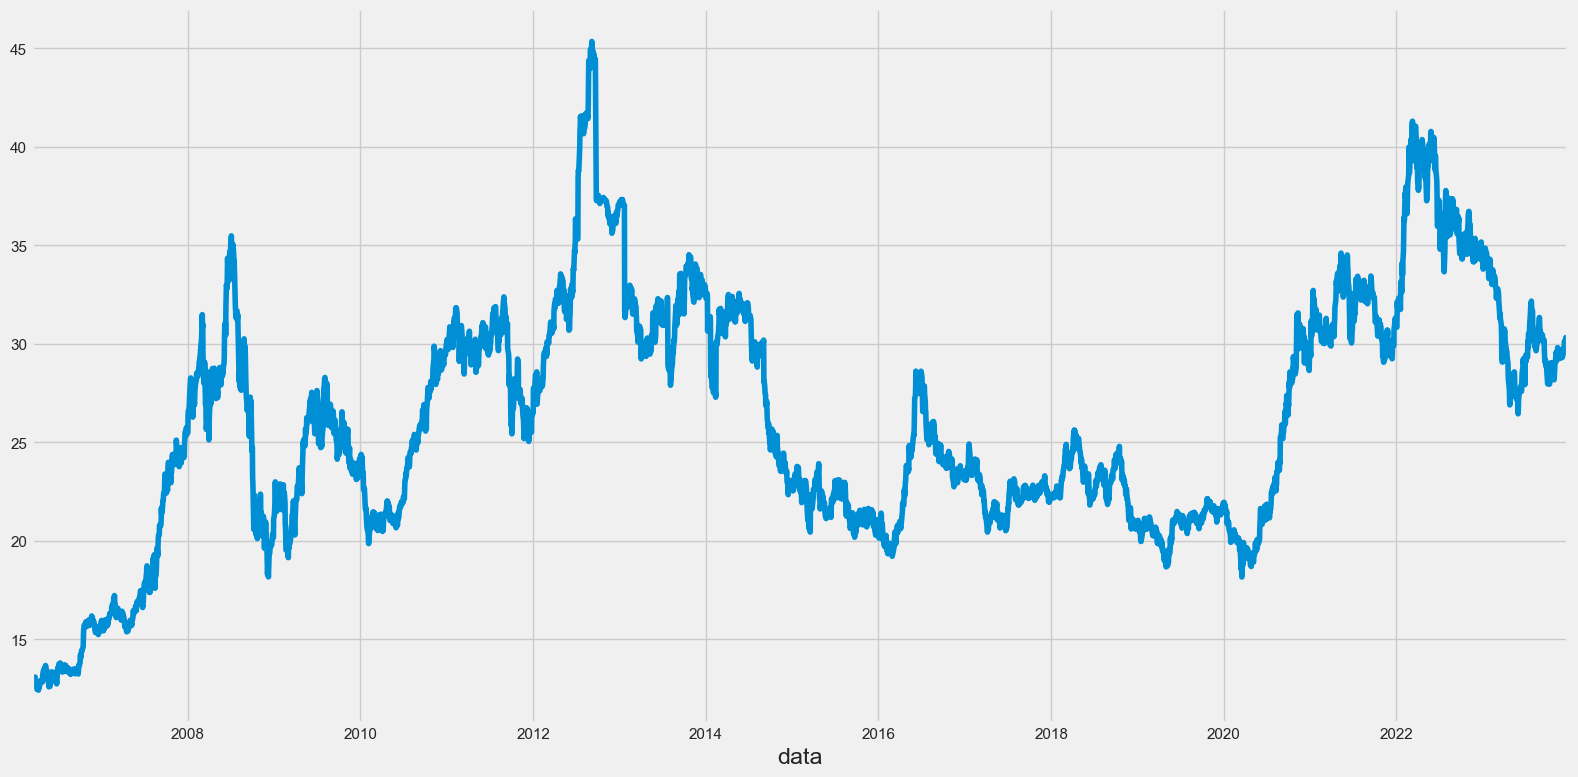

In [18]:
df_without_seasonal = df1['à_vista_dolar'] - seasonal
img_df_without_seasonal = df_without_seasonal.plot()
#save_image(img=img_df_vale3_without_seasonal, name='img_df_vale3_without_seasonal')

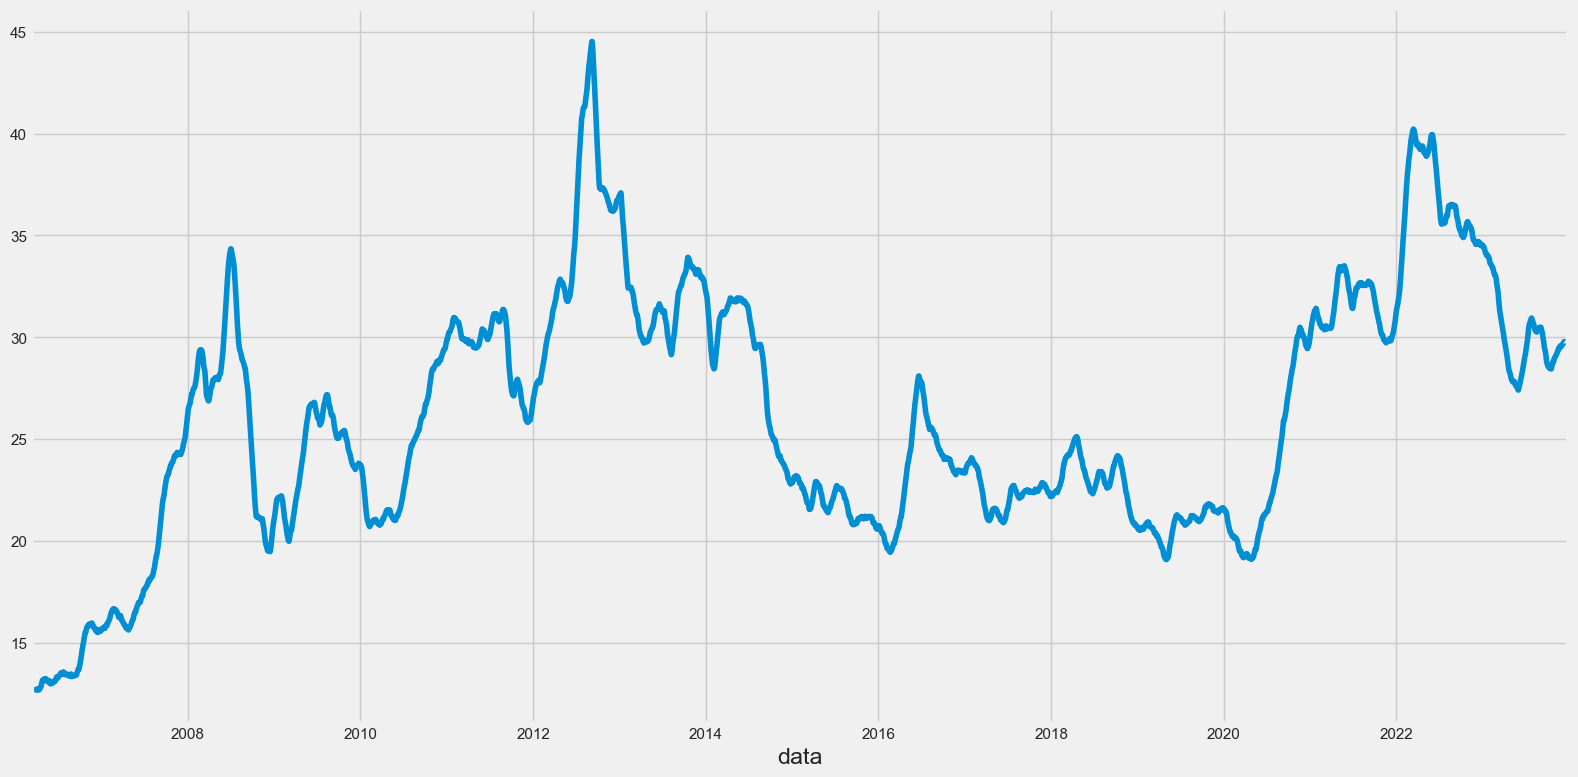

In [19]:
df_without_resid = df1['à_vista_dolar'] - residual
df_without_resid = df_without_resid.plot()

---

<br/>

### **Auto-correlation**
Modelos autoregressivos como ARIMA, supõem que as observações anteriores são úteis para prever o valor da próxima etapa de tempo.
<br/>
Quanto mais forte a correlação entre a variável de saída e uma variável defasada específica, mais peso o modelo de auto-regressão pode colocar nessa variável.

#### NOTES:
- A correlação é calculada entre a variável e ela mesma nas etapas de tempo anteriores, por isso o nome autocorrelação.
- Calcular a correlação também podem ajudar escolher as variáveis de atraso serão úteis em um modelo e quais não serão.
- Se as variáveis de atraso mostrarem baixa ou nenhuma correlação com a variável de saída, a série temporal pode não ser previsível.
- Usei Pearson

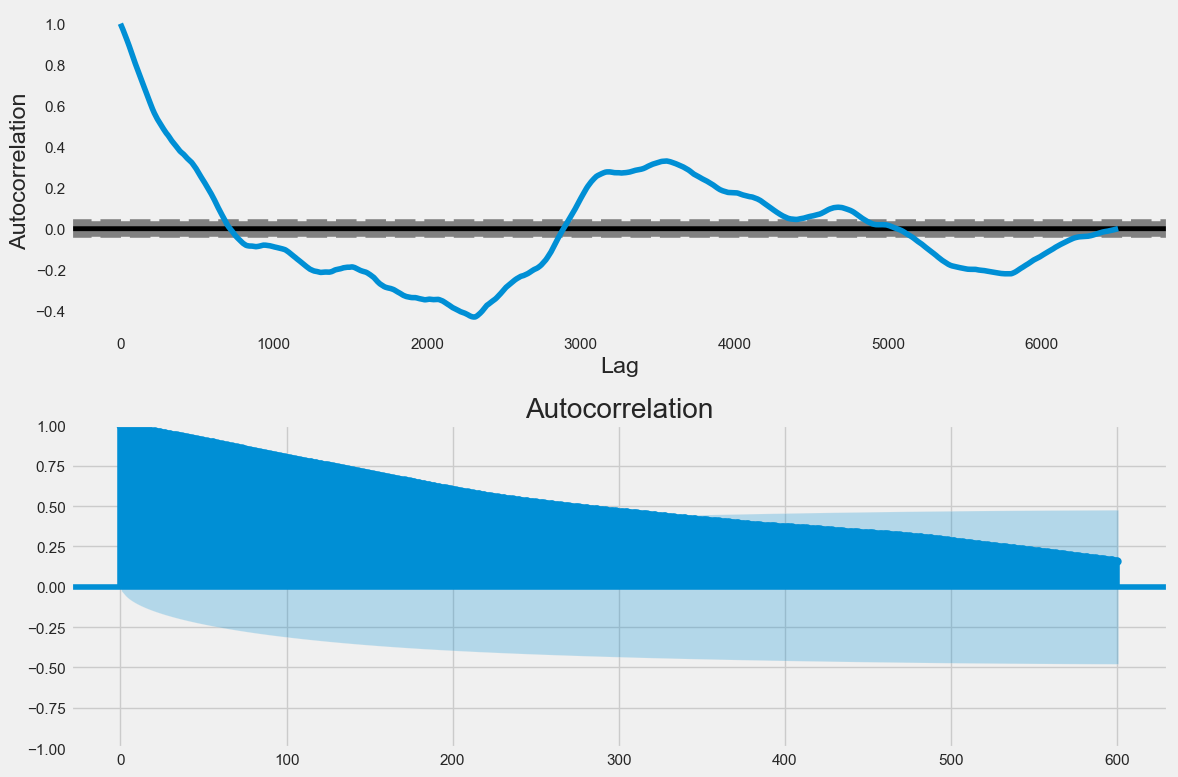

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Plot autocorrelation
autocorrelation_plot(df1['à_vista_dolar'], ax=ax1)

# Plot ACF
plot_acf(df1['à_vista_dolar'], ax=ax2, lags=600)

plt.show()

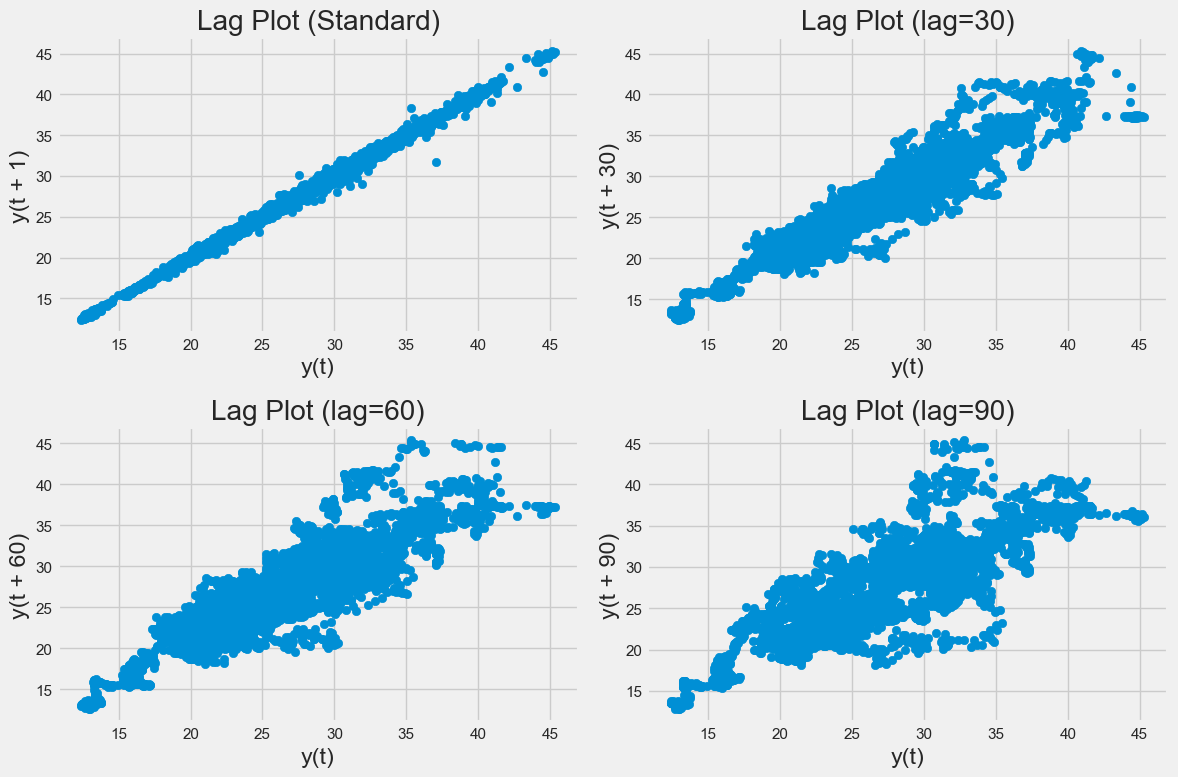

In [116]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0, 0].set_title('Lag Plot (Standard)')
axes[0, 0].set_xlabel('y(t)')
axes[0, 0].set_ylabel('y(t+1)')
lag_plot(df1['à_vista_dolar'], ax=axes[0, 0])

axes[0, 1].set_title('Lag Plot (lag=30)')
axes[0, 1].set_xlabel('y(t)')
axes[0, 1].set_ylabel('y(t+30)')
lag_plot(df1['à_vista_dolar'], lag=30, ax=axes[0, 1])

axes[1, 0].set_title('Lag Plot (lag=60)')
axes[1, 0].set_xlabel('y(t)')
axes[1, 0].set_ylabel('y(t+60)')
lag_plot(df1['à_vista_dolar'], lag=60, ax=axes[1, 0])

axes[1, 1].set_title('Lag Plot (lag=90)')
axes[1, 1].set_xlabel('y(t)')
axes[1, 1].set_ylabel('y(t+90)')
lag_plot(df1['à_vista_dolar'], lag=90, ax=axes[1, 1])

plt.tight_layout()
plt.show()


<br/>

### **Verificando a estacionariedade da ST**
É preciso garantir que os dados são estacionários. Significa que a série temporal possui um comportamento ao longo do tempo e que possui uma alta probabilidade de seguir este mesmo comportamento no futuro.

Visualmente a série não é estacionária. Para garantir o comportamento dessa série vou plotar as estatíticas de rolagem( ma, var) e fazer o teste de Dickey-Fuller.


Então neste teste avalio duas hipóteses:
- Hipótese nula (H0) : não é estacionária. Tem alguma estrutura dependente do tempo.
- Hipótese alternativa (H1) : é estacionária. Não tem estrutura dependente do tempo.

Uma ST com média, variância e covariância constante seria parecida com o plot abaixo.

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/ns6-e1536674898419.png" width=\"20%\"></center>

In [71]:
def test_stationarity(timeseries):

    # determing rolling statistics
    rolmean = timeseries.rolling(window=30, center=False).mean()
    rolstd  = timeseries.rolling(window=30, center=False).std()

    # plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


    # perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items(): # type: ignore
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

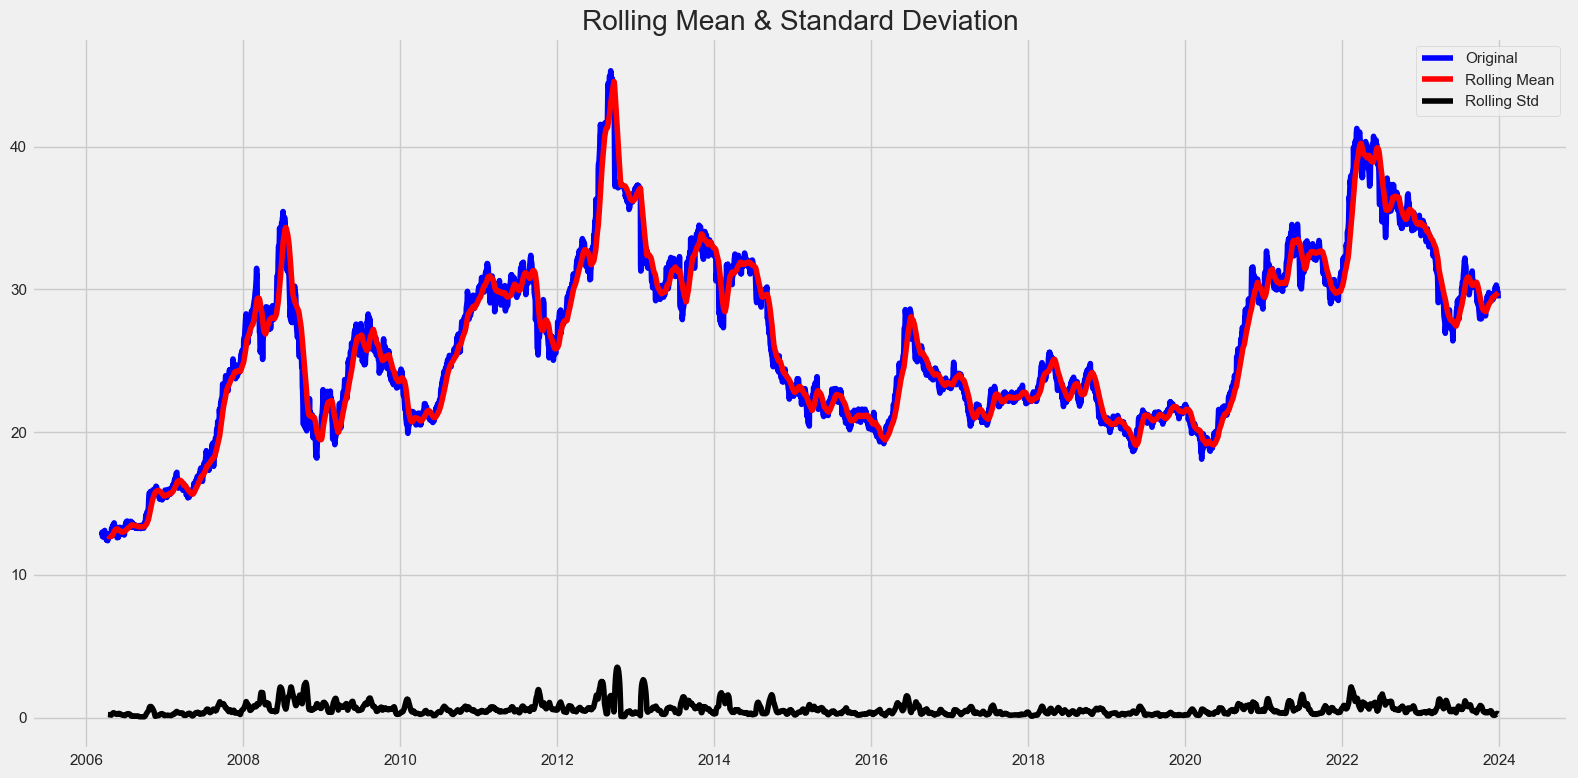

Results of Dickey-Fuller Test:
Test Statistic                  -2.63
p-value                          0.09
Lags Used                        2.00
Number of Observations Used   6497.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [72]:
test_stationarity(df1['à_vista_dolar'])

<br/>

**NOTES**
<br/>
- Usado `autolag='AIC'` para a própia função determinar o lag, escolhendo o menor valor observado.
- **Test Statistic > Critical Value (1%)**, então a H0 é aceita, ou seja, não se tem estacionariedade na ST explorada.
- O `p-value` > que 0.05 também indica o mesmo.
- Neste caso se faz necessário deixar a ST estacionária !

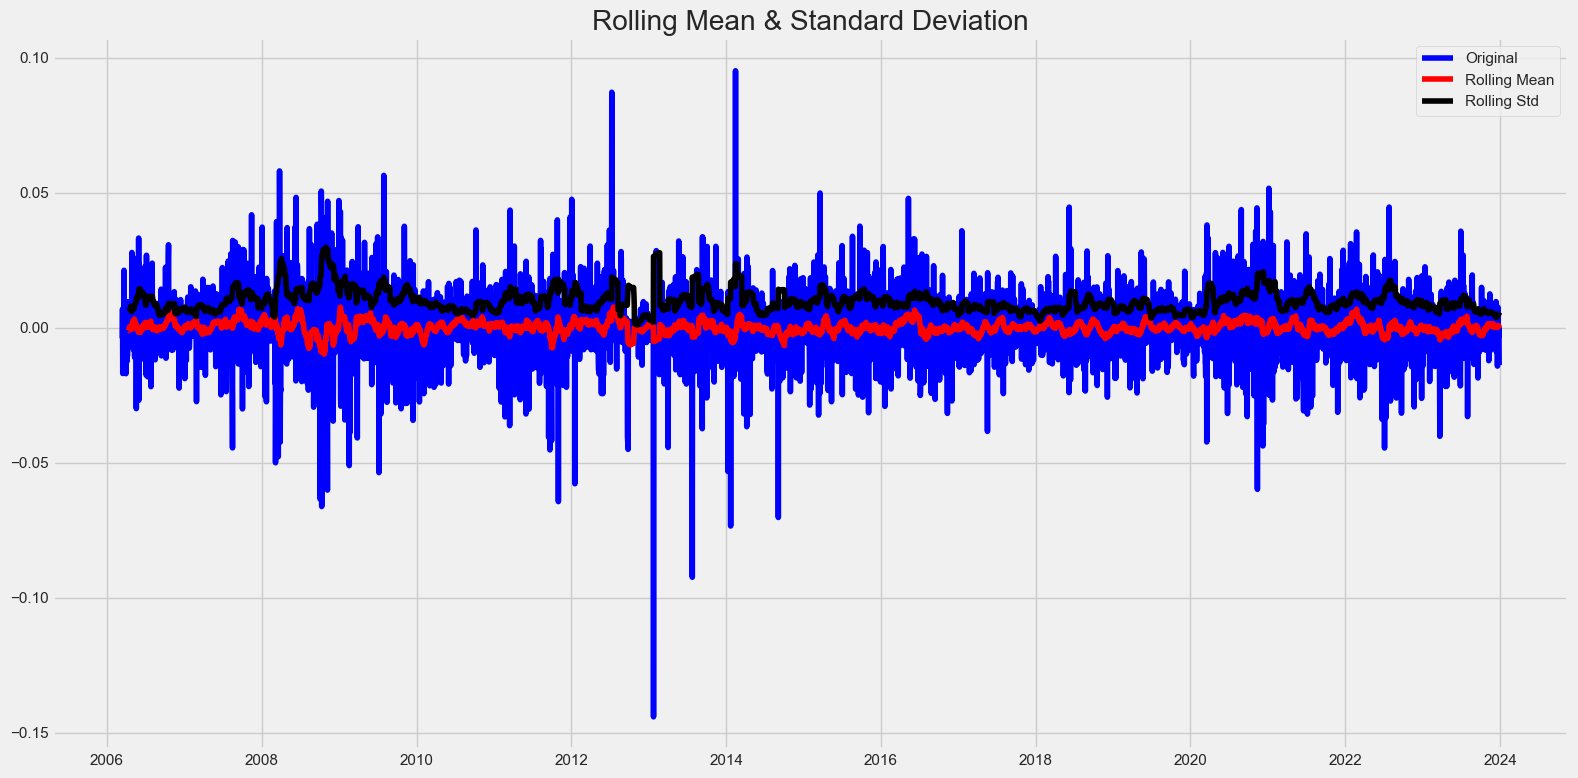

Results of Dickey-Fuller Test:
Test Statistic                 -54.40
p-value                          0.00
Lags Used                        1.00
Number of Observations Used   6497.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [80]:
df1_return = df1['à_vista_dolar'].pct_change().dropna()
test_stationarity(df1_return)

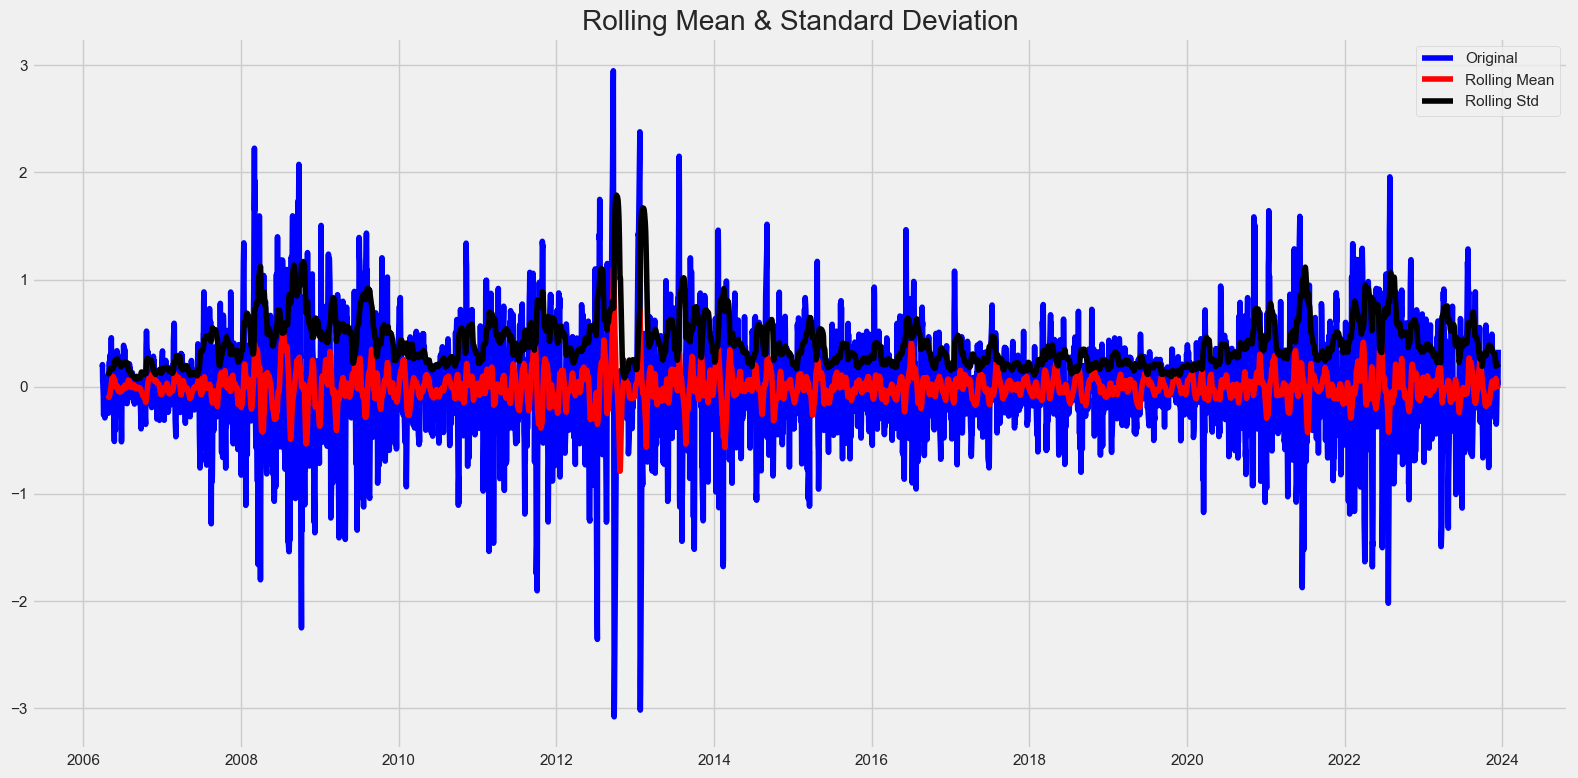

Results of Dickey-Fuller Test:
Test Statistic                 -19.43
p-value                          0.00
Lags Used                       35.00
Number of Observations Used   6434.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [77]:
residual.dropna(inplace=True)
test_stationarity(residual)

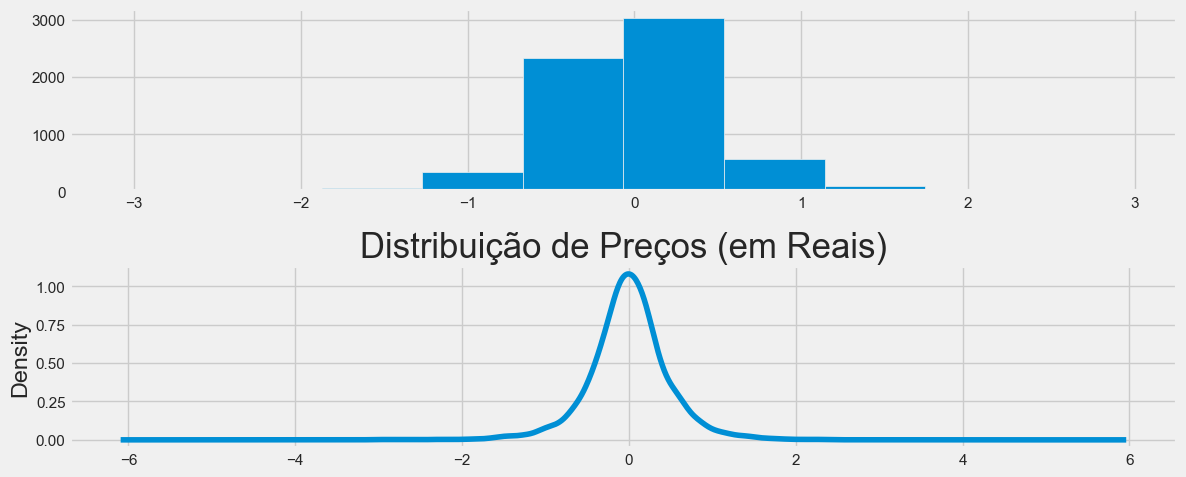

In [127]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,5))
residual.hist(ax=ax1)
residual.plot(kind='kde', ax=ax2)
plt.title(f'Distribuição de Preços (em Reais)', fontsize=25)
plt.show();

---

## **5. Preparação de dados: engenharia de recursos**

In [95]:
cols = ['data', 'preco', 'retorno', 'residuos', 'tendencia', 'sazonalidade']

In [96]:
df2 = pd.DataFrame(columns=cols)
df2.head()

,data,preco,retorno,residuos,tendencia,sazonalidade


In [97]:
df2['data'] = df1['data']
df2.head()

,data,preco,retorno,residuos,tendencia,sazonalidade
data,,,,,,
2006-03-13,2006-03-13,NaN,NaN,NaN,NaN,NaN
2006-03-14,2006-03-14,NaN,NaN,NaN,NaN,NaN
2006-03-15,2006-03-15,NaN,NaN,NaN,NaN,NaN
2006-03-16,2006-03-16,NaN,NaN,NaN,NaN,NaN
2006-03-17,2006-03-17,NaN,NaN,NaN,NaN,NaN


In [98]:
df2['preco'] = df1['à_vista_dolar']
df2.head()

,data,preco,retorno,residuos,tendencia,sazonalidade
data,,,,,,
2006-03-13,2006-03-13,12.96,NaN,NaN,NaN,NaN
2006-03-14,2006-03-14,12.91,NaN,NaN,NaN,NaN
2006-03-15,2006-03-15,13.00,NaN,NaN,NaN,NaN
2006-03-16,2006-03-16,12.78,NaN,NaN,NaN,NaN
2006-03-17,2006-03-17,12.68,NaN,NaN,NaN,NaN


In [99]:
df2['tendencia'] = trend.values
df2.head(20)

,data,preco,retorno,residuos,tendencia,sazonalidade
data,,,,,,
2006-03-13,2006-03-13,12.96,NaN,NaN,NaN,NaN
2006-03-14,2006-03-14,12.91,NaN,NaN,NaN,NaN
2006-03-15,2006-03-15,13.00,NaN,NaN,NaN,NaN
2006-03-16,2006-03-16,12.78,NaN,NaN,NaN,NaN
2006-03-17,2006-03-17,12.68,NaN,NaN,NaN,NaN
2006-03-18,2006-03-18,12.70,NaN,NaN,NaN,NaN
2006-03-19,2006-03-19,12.71,NaN,NaN,NaN,NaN
2006-03-20,2006-03-20,12.73,NaN,NaN,NaN,NaN
2006-03-21,2006-03-21,12.67,NaN,NaN,NaN,NaN


In [100]:
df2['sazonalidade'] = seasonal.values
df2.head(20)

,data,preco,retorno,residuos,tendencia,sazonalidade
data,,,,,,
2006-03-13,2006-03-13,12.96,NaN,NaN,NaN,-0.02
2006-03-14,2006-03-14,12.91,NaN,NaN,NaN,0.01
2006-03-15,2006-03-15,13.00,NaN,NaN,NaN,0.01
2006-03-16,2006-03-16,12.78,NaN,NaN,NaN,0.01
2006-03-17,2006-03-17,12.68,NaN,NaN,NaN,-0.01
2006-03-18,2006-03-18,12.70,NaN,NaN,NaN,-0.01
2006-03-19,2006-03-19,12.71,NaN,NaN,NaN,-0.01
2006-03-20,2006-03-20,12.73,NaN,NaN,NaN,-0.01
2006-03-21,2006-03-21,12.67,NaN,NaN,NaN,-0.04


In [101]:
residuos = residual.values

In [102]:
df2 = df2[30:]

In [103]:
df2['residuos'] = residuos

In [90]:
df2

,data,preco,df1_return,residuos,tendencia,sazonalidade
data,,,,,,
2006-04-12,2006-04-12,12.54,NaN,0.18,12.69,-0.02
2006-04-13,2006-04-13,12.54,NaN,0.19,12.69,0.01
2006-04-14,2006-04-14,12.60,NaN,0.21,12.71,0.01
2006-04-15,2006-04-15,12.66,NaN,0.05,12.72,0.01
2006-04-16,2006-04-16,12.71,NaN,0.02,12.74,-0.01
...,...,...,...,...,...,...
2023-12-24,2023-12-24,29.97,NaN,0.06,NaN,0.07
2023-12-25,2023-12-25,29.88,NaN,0.01,NaN,0.05
2023-12-26,2023-12-26,29.78,NaN,0.01,NaN,0.02


In [105]:
df2['retorno'] = df1_return
df2

,data,preco,retorno,residuos,tendencia,sazonalidade,retornos
data,,,,,,,
2006-04-12,2006-04-12,12.54,0.00,0.18,12.69,-0.02,0.00
2006-04-13,2006-04-13,12.54,0.00,0.19,12.69,0.01,0.00
2006-04-14,2006-04-14,12.60,0.00,0.21,12.71,0.01,0.00
2006-04-15,2006-04-15,12.66,0.00,0.05,12.72,0.01,0.00
2006-04-16,2006-04-16,12.71,0.00,0.02,12.74,-0.01,0.00
...,...,...,...,...,...,...,...
2023-12-24,2023-12-24,29.97,-0.00,0.06,NaN,0.07,-0.00
2023-12-25,2023-12-25,29.88,-0.00,0.01,NaN,0.05,-0.00
2023-12-26,2023-12-26,29.78,-0.00,0.01,NaN,0.02,-0.00


#### Gerar diferença

In [106]:
df2['diff_1'] = df2['preco'].diff(periods=1)
df2['diff_2'] = df2['preco'].diff(periods=2)
df2['diff_3'] = df2['preco'].diff(periods=3)
df2['diff_4'] = df2['preco'].diff(periods=4)
df2['diff_5'] = df2['preco'].diff(periods=5)

df2.dropna(inplace=True)

In [108]:
df2 = df2.drop('retornos', axis=1)
df2

,data,preco,retorno,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,,,
2006-04-17,2006-04-17,12.77,0.00,-0.04,12.77,-0.01,0.06,0.11,0.17,0.23,0.23
2006-04-18,2006-04-18,12.88,0.01,-0.09,12.79,-0.01,0.11,0.17,0.22,0.28,0.34
2006-04-19,2006-04-19,12.82,-0.00,-0.26,12.82,-0.01,-0.06,0.05,0.11,0.16,0.22
2006-04-20,2006-04-20,12.75,-0.01,-0.25,12.85,-0.04,-0.07,-0.13,-0.02,0.04,0.09
2006-04-21,2006-04-21,12.80,0.00,-0.13,12.88,-0.04,0.05,-0.02,-0.08,0.03,0.09
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-09,2023-12-09,29.76,0.00,-0.13,29.72,-0.02,0.01,0.18,0.32,0.43,0.46
2023-12-10,2023-12-10,29.76,0.00,-0.20,29.74,0.01,0.00,0.01,0.18,0.32,0.43
2023-12-11,2023-12-11,29.77,0.00,-0.26,29.76,0.01,0.01,0.01,0.02,0.19,0.33


---

## **6. Save Clean Data**

In [94]:
df2.to_csv(r'C:\Users\Lucas S\OneDrive\Documents\ADM_UFPB\TCC1\db_soja_modificado\nome_do_arquivo.csv', sep=',', index=False, encoding='utf8')

---